<a href="https://colab.research.google.com/github/sajjadhaghighat/NeuralNetwork/blob/master/MLP_Executed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In the name of God
# Sajjad Haghighat

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
import statistics

In [2]:
class MLP(object):
     def __init__(self, data, layers_size , act_func , etha = 0.1, rand_scale = 0.1):
        self.dataset = data
        self.layers_size = layers_size
        self.etha = etha
        self.rand_scale = rand_scale
        self.neti = [None] * (len(layers_size)-1)
        self.oi = [None] * (len(layers_size) - 1)
        self.delta = [None] * (len(layers_size) - 1)
        self.act_func = self.sigmoid if act_func=="sigmoid" else self.relu
        self.der_func = self.sigmoid_derivative if act_func == "sigmoid" else self.relu_derivative
        self.error = []
        self.target = []
        self.pred = []
        self.acclist = []
        #self.create_xavier_weights()
        self.create_weights()

     def create_xavier_weights(self):
         nl = self.layers_size
         self.wi = [None] * (len(nl) - 1)
         self.wi_new = [None] * (len(nl) - 1)
         for i in range(len(self.wi)):
             self.wi[i] = np.random.randn(nl[i+1], nl[i]+1) / np.sqrt(nl[i])

     def create_weights(self):
         nl = self.layers_size
         self.wi = [None] * (len(nl) - 1)
         self.wi_new = [None] * (len(nl) - 1)
         for i in range(len(self.wi)):
             self.wi[i] = np.random.normal(0, self.rand_scale, (nl[i+1], nl[i]+1))

     def train(self , epoches=1):
         self.error = []
         self.target = []
         self.pred = []
         self.acclist = []
         for epoch in range(epoches):
             for row in self.dataset:
                Y = row[0]
                X = np.append((row[1:] - row[1:].mean()) / statistics.stdev(row[1:]), 1)
                network , expected = self.feedforward(X, Y)
                self.backpropagation(X, network, expected)
         plt.show()

     def test(self, test):
         self.error = []
         self.target = []
         self.pred = []
         self.acclist = []
         for row in test:
             Y = row[0]
             X = np.append((row[1:] - row[1:].mean()) / statistics.stdev(row[1:]), 1)
             self.feedforward(X, Y)

     def feedforward(self, X, Y):
         X = np.array(X , ndmin=2)
         nl = len(self.layers_size)
         for i in range(nl-1):
            net = np.dot(self.wi[i], X.T)
            self.neti[i] = net[:, 0]
            if i == nl-2:
                #tmp = self.act_func(net)
                tmp = self.softmax(net)
                self.oi[i] = tmp[:, 0]
            else:
                tmp = self.act_func(net)
                self.oi[i] = np.append(tmp, 1)#bias
                X = np.array(self.oi[i], ndmin=2)

         #Y = self.squared_error(self.oi[-1].copy(),Y)
         Y = self.pre_celoss(self.oi[-1].copy(), Y)
         return self.oi[-1], Y

     def backpropagation(self ,X, network , expected):
         for i in range(len(self.layers_size)-2,-1,-1):
             if i == len(self.layers_size)-2:
                 # last layer
                 #delta = -2 * self.der_func(self.neti[i]) * (expected - network)
                 delta =  (network - expected)
                 self.delta[i] = delta
                 wi = self.wi[i].copy()
                 for j in range(len(delta)):
                     RondE = self.oi[i - 1] * delta[j]
                     wi[j] = wi[j] - self.etha * RondE
                 self.wi_new[i] = wi
             else:
                 #Hidden layers
                 wi = self.wi[i+1]
                 di = self.delta[i+1]
                 delta =  self.der_func(self.neti[i]) * [sum( wi[:,j] * di) for j in range(wi.shape[1] - 1)]
                 self.delta[i] = delta
                 wi = self.wi[i].copy()
                 for j in range(len(delta)):
                     RondE = self.oi[i - 1] * delta[j] if i > 0 else X * delta[j]
                     wi[j] = wi[j] - self.etha * RondE
                 self.wi_new[i] = wi
         self.print_norm()
         self.wi = self.wi_new.copy()


     def squared_error(self, o, d):
         target = np.zeros(10)
         target[d] = 1
         predict = o.copy()
         o[o == np.amax(o)] = 1
         o[o != 1] = 0
         self.error = np.append(self.error,((target - predict) ** 2).sum())
         self.pre_accuracy(o, target)
         return target

     def mse(self):
         print("MSE : ", self.error.mean())

     def pre_accuracy(self,o,d):
         if np.all(d == o):
           self.target = np.append(self.target,1)
           self.pred = np.append(self.pred, 1)
         else:
           self.target = np.append(self.target, 1)
           self.pred = np.append(self.pred, 0)

         self.acclist = np.append(self.acclist , accuracy_score(self.target,self.pred) * 100)

     def accuracy(self , leg):
         print("Accuracy : ", accuracy_score(self.target,self.pred) * 100)
         plt.title(leg + ' Accuracy')
         plt.ylim(0.0, 100.0)
         plt.plot([i for i in range(len(self.acclist))], self.acclist)
         plt.show()

     def pre_celoss(self, o, d):
         target = np.zeros(10)
         target[int(d)] = 1
         predict = o.copy()
         o[o == np.amax(o)] = 1
         o[o != 1] = 0
         self.error = np.append(self.error, self.cross_entropy(predict,target))
         self.pre_accuracy(o, target)
         return target

     def celoss(self):
         print("CE_Loss : ", self.error.mean())


     def sigmoid(self, z):
         result = 1.0 / (1.0 + np.exp(-z))
         return result

     def relu(self, z):
         if np.isscalar(z):
             result = np.max((z, 0))
         else:
             zero_aux = np.zeros(z.shape)
             meta_z = np.stack((z, zero_aux), axis=-1)
             result = np.max(meta_z, axis=-1)
         return result

     def sigmoid_derivative(self, z):
         result = self.sigmoid(z) * (1 - self.sigmoid(z))
         return result

     def relu_derivative(self, z):
         result = 1 * (z > 0)
         return result

     def softmax(self, x):
         e_x = np.exp(x - np.max(x))
         return e_x / e_x.sum(axis=0)

     def cross_entropy(self, predictions, targets, epsilon=1e-12):
         predictions = np.clip(predictions, epsilon, 1. - epsilon)
         N = predictions.shape[0]
         ce = -np.sum(targets * np.log(predictions + 1e-9))
         return ce

     def print_norm(self):
        st = len(self.layers_size) -1
        plt.ylim(0., .5)
        plt.plot([i for i in range(st)], [np.sqrt(np.square(self.wi[j]-self.wi_new[j]).sum()) for j in range(st)])
        plt.ylabel("Norm of Weight Matrix")

Training..........................


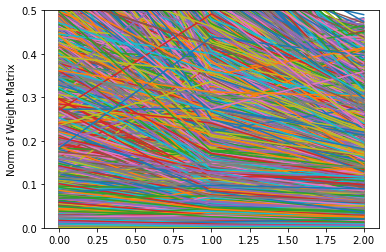

CE_Loss :  0.3022896609928872
Accuracy :  90.66


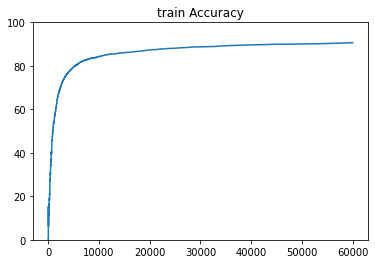

In [6]:
if __name__ == '__main__':
    start = time.time()
    X = pd.read_csv("mnist_train.csv")
    X = X.to_numpy()

    mlp = MLP(
        X,
        [784, 100, 50, 10],
        "sigmoid"
    )
    print("Training..........................")
    mlp.train()
    mlp.celoss()
    mlp.accuracy('train')

    """print("PCA Training..........................")
    y = X[:, 0]
    pca = PCA(n_components=200)
    X_reduced = pca.fit_transform(X[:, 1:])
    X = np.zeros((X_reduced.shape[0], X_reduced.shape[1] + 1))
    X[:, 0] = y
    X[:, 1:] = X_reduced
    mlp2 = MLP(
        X,
        [200, 100, 50, 10],
        "sigmoid"
    )
    mlp2.train()
    mlp2.celoss()
    mlp2.accuracy('PCA train')"""

Testing...........................
CE_Loss :  0.23644593338355185
Accuracy :  92.58


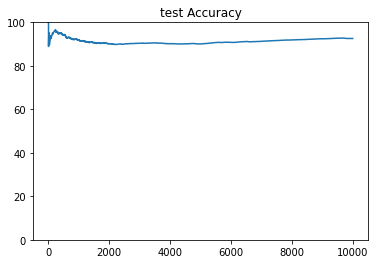

Execute Time :  1230.5723814964294



In [7]:
    print("Testing...........................")
    X = pd.read_csv("mnist_test.csv")
    X = X.to_numpy()
    mlp.test(X)
    mlp.celoss()
    mlp.accuracy('test')
    end = time.time()
    print("Execute Time : ", end - start)
    print("")